# COCO-ify Dissection Dataset

https://github.com/waspinator/pycococreator/blob/master/examples/shapes/shapes_to_coco.py for reference 

DOCKER FILE: abalajiaus/oct_ca:latest-fire or abalajiaus/oct_ca:latest-fire

In [1]:
%%time
!pip install git+git://github.com/waspinator/pycococreator.git@0.2.0

  Cloning git://github.com/waspinator/pycococreator.git (to revision 0.2.0) to /tmp/pip-req-build-asssaz81
  Running command git clone -q git://github.com/waspinator/pycococreator.git /tmp/pip-req-build-asssaz81
  Running command git checkout -q fba8f4098f3c7aaa05fe119dc93bbe4063afdab8
  Created wheel for pycococreatortools: filename=pycococreatortools-0.2.0-py3-none-any.whl size=7188 sha256=bf09dc17d7e2a02adfbec40defd48dcf7c9a3adbf1c502d26a0157775e50be59
  Stored in directory: /tmp/pip-ephem-wheel-cache-w7oknsye/wheels/31/49/b4/603bcbbca4b264e0f1189ebc2db4352d8a5720d746fc6c799c
Successfully built pycococreatortools
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
CPU times: user 73.3 ms, sys: 36.7 ms, total: 110 ms
Wall time: 3.8 s


In [2]:
%%time
!pip install git+git://github.com/waspinator/coco.git@2.1.0

  Cloning git://github.com/waspinator/coco.git (to revision 2.1.0) to /tmp/pip-req-build-sm41vszh
  Running command git clone -q git://github.com/waspinator/coco.git /tmp/pip-req-build-sm41vszh
  Running command git checkout -q cd69b031a5dafdd40c0b2c52bd4a9c5d7f11382e
  Created wheel for pycocotools: filename=pycocotools-2.1-cp36-cp36m-linux_x86_64.whl size=299500 sha256=e4f53f5dad203b6bc17e15d140bf24a03092e0523c1282c7ab9d295dc012af6a
  Stored in directory: /tmp/pip-ephem-wheel-cache-bg37s7_b/wheels/6a/fc/7d/91a76da8191691d4dc7c7144306007ce6472cb24f51051603e
Successfully built pycocotools
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
CPU times: user 269 ms, sys: 59.8 ms, total: 329 ms
Wall time: 13.1 s


In [3]:
from pycocotools.coco import COCO
import pycococreatortools.pycococreatortools as creator

In [4]:
import pycocotools.mask as m

In [35]:
from pathlib import Path
from fastai.vision import get_files
import PIL.Image as Image
import numpy as np
import matplotlib.pyplot as plt
import datetime
import json
from scipy.ndimage.measurements import label
import os
import shutil

In [159]:
def OCTDataToCOCO(im_path):
    INFO = {
        "description": "OCT dataset",
        "url": "tba",
        "version": "0.1.0",
        "year": 2020,
        "contributor": "abalajiaus",
        "date_created": datetime.datetime.utcnow().isoformat(' ')
    }

    LICENSES = [
        {
            "id": 1,
            "name": "VASCLAB",
            "url": "VASCLAB"
        }
    ]

    CATEGORIES = [
        {
            'id': 1,
            'name': 'lumen',
            'supercategory': 'feature',
        }

    ]
    coco = {
            "info": INFO,
            "licenses": LICENSES,
            "categories": CATEGORIES,
            "images": [],
            "annotations": []}
    
    label_path = im_path.parent/'labels'
    i=1
    anno_id = 0 #anno_id has to be unique
    for image_path in get_files(im_path, extensions='.jpg'):
        image = Image.open(image_path)
        image_id = image_path.name
        anno_path = label_path/image_id
        gt = Image.open(anno_path)

        assert (anno_path.stem == image_path.stem) # make sure label and image are corresponding
        assert (gt.size==image.size)
        gt = (np.array(gt)>200).astype(int)[:,:,0]
        assert (np.array_equal(gt, gt.astype(bool))) #make sure label is binary

        lab, num_instances = label(gt)

        image_info = creator.create_image_info(i,
                                                str(image_path),
                                                image.size)
        
        image_info['annotations'] = []
        
        for n in range(num_instances):
            tl=(lab==(n+1)).astype(int)
            category_info = {'id': 1, 'is_crowd': 0} #play with 1 or 0 here
            annotation_info = creator.create_annotation_info(anno_id,
                                                             i,
                                                             category_info,
                                                             tl,
                                                             image_size=image.size,
                                                             tolerance=1)

            if annotation_info is not None:
                annotation_info['bbox_mode']=0
                coco['annotations'].append(annotation_info)
                image_info['annotations'].append(annotation_info)
                anno_id+=1
        
        
        image_info['image_id'] = i
        image_info['sem_seg_file_name'] = str(anno_path)
        coco['images'].append(image_info)
        
        #if num_instances>1:
        #    pdb.set_trace()    
            
        #    return (image, image_info, l, tl, annotation_info)
        #    
        '''if annotation_info is not None:
            coco['annotations'].append(annotation_info)'''
        i+=1
        #if i%1000==0: print(i)
    return coco

## Reformat data structure to include train, validation, test


In [160]:
original_data_path = Path('/workspace/oct_ca_seg/data_oct/')

In [157]:
COCO_path = Path('/workspace/oct_ca_seg/COCOdata/')
train = COCO_path/'train'
valid = COCO_path/'valid'
test = COCO_path/'test'

In [38]:
%%time
for d in get_files(original_data_path, recurse=True, extensions='.jpg'):
    #print(d.stem, d.parent.name)
    stem = int(d.stem)
    parent = d.parent.name
    

    if stem <8408: t = train
    elif stem > 8408 and stem <11011: t = valid
    elif stem >11011: t = test
    
    dest = t/(parent + '/' + d.name)
    
    shutil.copy(d, dest)

CPU times: user 2.91 s, sys: 1.93 s, total: 4.84 s
Wall time: 8.21 s


In [161]:
%%time
trains = OCTDataToCOCO(train/'images')

CPU times: user 2min 21s, sys: 5.35 s, total: 2min 26s
Wall time: 2min 26s


In [162]:
len(trains['images']), len(trains['annotations'])

(8410, 8410)

In [164]:
%%time
valids = OCTDataToCOCO(valid/'images')

CPU times: user 43.3 s, sys: 318 ms, total: 43.6 s
Wall time: 44.2 s


In [166]:
len(valids['images']), len(valids['annotations'])

(2602, 2602)

In [167]:
%%time
tests = OCTDataToCOCO(test/'images')

CPU times: user 16 s, sys: 95.5 ms, total: 16.1 s
Wall time: 16.1 s


In [169]:
len(tests['images']), len(tests['annotations'])

(999, 999)

In [28]:
valids['images'][10].keys()

dict_keys(['id', 'file_name', 'width', 'height', 'date_captured', 'license', 'coco_url', 'flickr_url', 'annotations', 'image_id', 'sem_seg_file_name'])

In [171]:
with open(train/'images/annotations.json', 'w') as output_json_file:
    json.dump(trains, output_json_file)

In [172]:
with open(valid/'images/annotations.json', 'w') as output_json_file:
    json.dump(valids, output_json_file)

In [173]:
with open(test/'images/annotations.json', 'w') as output_json_file:
    json.dump(tests, output_json_file)

Difference is because some annotations are blank and thus arent added.

# Visualise COCO dataset

https://github.com/waspinator/pycococreator/blob/master/examples/shapes/visualize_coco.ipynb for reference

In [174]:
train

PosixPath('/workspace/oct_ca_seg/COCOdata/train')

In [175]:
anno_file = train/'images/annotations.json'

In [176]:
coco_dataset = COCO(anno_file)

loading annotations into memory...
Done (t=0.43s)
creating index...
index created!


In [177]:
categories = coco_dataset.loadCats(coco_dataset.getCatIds())

In [178]:
categories

[{'id': 1, 'name': 'lumen', 'supercategory': 'feature'}]

In [179]:
category_ids = coco_dataset.getCatIds(catNms=['lumen'])

In [180]:
category_ids

[1]

In [181]:
image_ids = coco_dataset.getImgIds(catIds=category_ids)

In [182]:
image_ids[0:5]

[1, 2, 3, 4, 5]

In [183]:
import pylab
import skimage.io as io

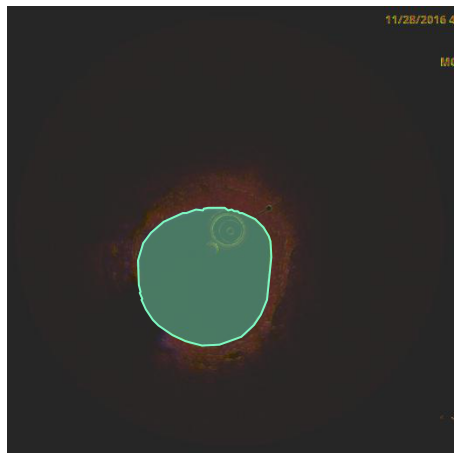

In [190]:
image_data = coco_dataset.loadImgs(image_ids[np.random.randint(0, len(image_ids))])[0]

# load and display instance annotations
image = io.imread(image_data['file_name'])

plt.imshow(image); plt.axis('off')
pylab.rcParams['figure.figsize'] = (8.0, 10.0)
annotation_ids = coco_dataset.getAnnIds(imgIds=image_data['id'], catIds=category_ids, iscrowd=None)
annotations = coco_dataset.loadAnns(annotation_ids)
coco_dataset.showAnns(annotations)